In [3]:
import numpy as np
from numpy import linalg as LA
import random
import scipy.stats as STATS
import math
import dgl
import pickle
import os
import torch
from tqdm.notebook import trange, tqdm

In [4]:
os.sys.path.insert(0, '../')

In [5]:
%load_ext autoreload
%autoreload 1

# Data Generation

In [6]:
'''
x is a spectrum sorted in ascending order
'''

def high_pass(x, cutoff=1.0):
    return 1/(1 + np.exp(-50*(x-cutoff)))
def low_pass(x, cutoff=1.0):
    return 1-1/(1 + np.exp(-50*(x-cutoff)))
def band_pass(x, width=0.05):
    return -1/(1 + np.exp(-100*(x-(1+width)))) + 1/(1 + np.exp(-100*(x-(1-width))))

# Groundtruth functions
functions = {
    'SGS_HIGH_PASS':high_pass,
    'SGS_LOW_PASS':low_pass,
    'SGS_BAND_PASS':band_pass
}

In [9]:
def creat_graph(n = 500, density = 0.5):
    
    A = np.zeros((n,n))
    G = dgl.DGLGraph()
    G.add_nodes(n)

    rand_mat = np.random.random((n,n))
    rand_mat = rand_mat + rand_mat.transpose()

    A[rand_mat < density] = 1.0
    A[range(n), range(n)] = 0.0
        
    # add edges
    edges = np.where(A == 1.0)
    G.add_edges(edges[0], edges[1])
    
    # normalize A
    D = np.sum(A, axis=1)
    D[np.where(D > 0)] = 1.0 / D[np.where(D > 0)]
    D = np.diag(D)
    
    for i in range(n):
        D[i][i] = math.sqrt(D[i][i]) # D = D^{-1/2}
    A = np.matmul(np.matmul(D, A),D) # normalize A 
    
    # L
    L = np.identity(n) - A

    # compute the eigenvalues and eigenvectors
    V, U = LA.eigh(L)

    return G, V, U

def add_sig(G, U):
    n = G.number_of_nodes()

    # set the spectrum of the signal in the graph
    spec = np.zeros((n,1))

    para1 = (random.randint(1, 50)/10, random.randint(1, 50)/10)
    para2 = (random.randint(1, 50)/10, random.randint(1, 50)/10)

    norm1 = (random.randint(0, n), random.randint(round(n/18), round(n/9)))
    scale1 = random.randint(5,20)/10/STATS.norm(norm1[0], norm1[1]).pdf(norm1[0])
    norm2 = (random.randint(0, n), random.randint(round(n/27), round(n/18)))
    scale2 = random.randint(5,20)/10/STATS.norm(norm2[0], norm2[1]).pdf(norm2[0])
    norm3 = (random.randint(0, n), random.randint(round(n/36), round(n/27)))
    scale3 = random.randint(5,20)/10/STATS.norm(norm3[0], norm3[1]).pdf(norm3[0])
    norm4 = (random.randint(0, n), random.randint(round(n/45), round(n/36)))
    scale4 = random.randint(5,20)/10/STATS.norm(norm4[0], norm4[1]).pdf(norm4[0])

    if n >= 2:
        for i in range(1,n-1):
            spec[i][0] = STATS.beta(para1[0], para1[1]).pdf(i/n) + STATS.beta(para2[0], para2[1]).pdf(i/n)

        maxinum = max(spec[:,0])
        for i in range(n):
            spec[i][0] = spec[i][0]/maxinum \
                        + STATS.norm(norm1[0],norm1[1]).pdf(i)*scale1 \
                        + STATS.norm(norm2[0],norm2[1]).pdf(i)*scale2 \
                        + STATS.norm(norm3[0],norm3[1]).pdf(i)*scale3 \
                        + STATS.norm(norm4[0],norm4[1]).pdf(i)*scale4
        spec[0][0] = spec[1][0]
        spec[n-1][0] = spec[n-2][0]
    
    # perform inverse fourier transform onto the spectrum to obtain the signal in vertex domain
    X = np.matmul(U, spec)
    
    # add the noise to X
    X += np.random.normal(0, random.randrange(5, 35)/100, X.shape)

    # add X to G
    G.ndata['feat'] = torch.from_numpy(X) # shape (n,1)

def get_Y(G, V, U, func):
    # V = [func(v) for v in V]
    V = func(V)
    P = np.matmul(np.matmul(U, np.diag(V)), U.T)
    X = G.ndata['feat'].numpy()
    Y = np.matmul(P,X)
    return torch.from_numpy(Y)

In [10]:
# range of node number
n_range = (80, 120)
# p = 0.5 * (density) ^ 2
density = 0.2
# split config
splits = {'train': 1000, 'val': 1000, 'test': 2000}

# start generating
for dataset_kind in functions:
    func = functions[dataset_kind]

    f = open(dataset_kind + '.pkl', 'wb+')

    split_datasets = []
    
    for j in splits:
        graph_list = []
        graph_labels = []

        dataset_name = dataset_kind + '-' + j

        for i in trange(splits[j], desc=dataset_name):
            n = random.randint(n_range[0], n_range[1])
            G, V, U = creat_graph(n, density)
            add_sig(G, U)
            Y = get_Y(G, V, U, func)

            graph_list.append(G)
            graph_labels.append(Y)

        split_datasets.append((graph_list, graph_labels))

    pickle.dump(split_datasets, f)
    f.close()

# Visualize Dataset

In [7]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib import rcParams
import seaborn as sns
sns.set_theme(style="whitegrid")
rcParams['figure.dpi'] = 150

def plot_spectrum(G, Ys, U, title_ls=[], name=None):
    outs = []
    for Y in Ys:
        Y = Y.numpy()
        outs.append(np.matmul(U.T, Y))
    
    fig, axs = plt.subplots(1, len(outs), sharey = True, figsize=(10, 3), constrained_layout=True)
    for i in range(len(outs)):
        axs[i].plot(outs[i])
        axs[i].set_xlabel('Frequency')
    
    
    axs[0].annotate('Magnitude',
        xy=(0, 0.5), xytext=(-axs[0].yaxis.labelpad - 15, 0),
        xycoords=axs[0].yaxis.label, textcoords='offset points',
        size=12, ha='right', va='center', rotation=90)
    
    for i in range(len(outs)):
        axs[i].annotate(title_ls[i],
                    xy=(0.5, 1), xytext=(0, 25), xycoords='axes fraction', textcoords='offset points',
                    size=15, ha='center', va='baseline')
    
    fig.suptitle(name)
    if not name is None:
        if not os.path.exists('../../vis_out'):
            os.makedirs('../../vis_out')
        fig.savefig('../../vis_out/vis_sgs_%s.pdf' % name)


def adj_eig_decomp(G):
    A = G.adjacency_matrix(transpose=True).to_dense().to(dtype=torch.float64)
    A[A > 0] = 1.0

    D_inv = torch.sum(A, dim=1)
    D_inv[torch.where(D_inv > 0)] = 1 / D_inv[np.where(D_inv > 0)]
    D_inv = torch.diag(D_inv)
    A_n = torch.sqrt(D_inv) @ A @ torch.sqrt(D_inv ** 0.5)

    L = torch.eye(A_n.shape[0]) - A_n

    Lam, U = torch.symeig(L, eigenvectors=True)

    return Lam, U
    

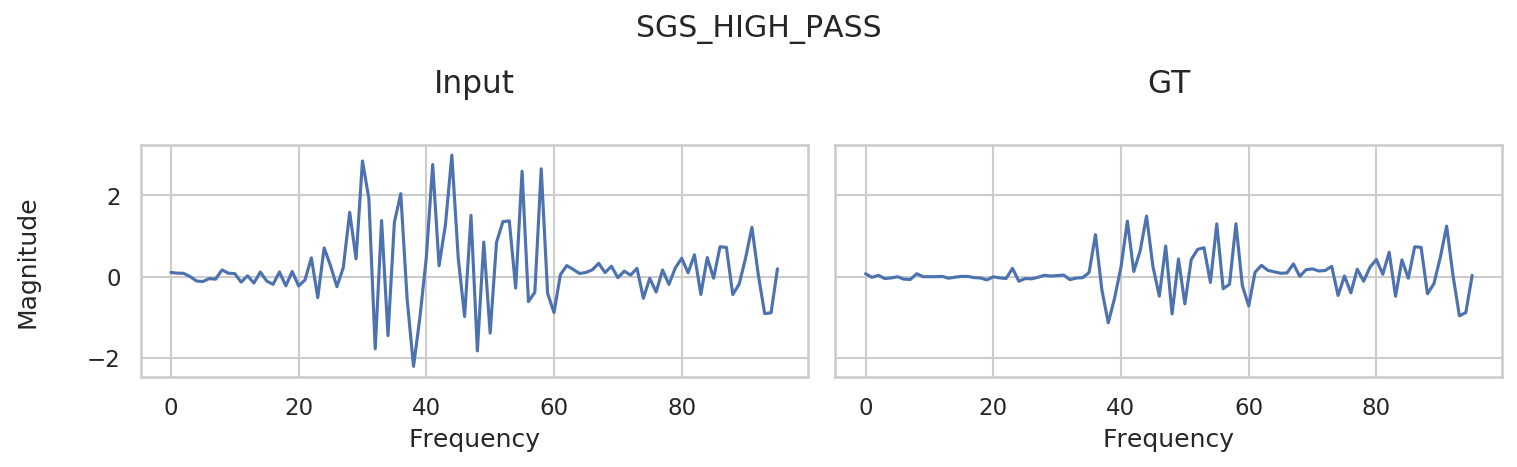

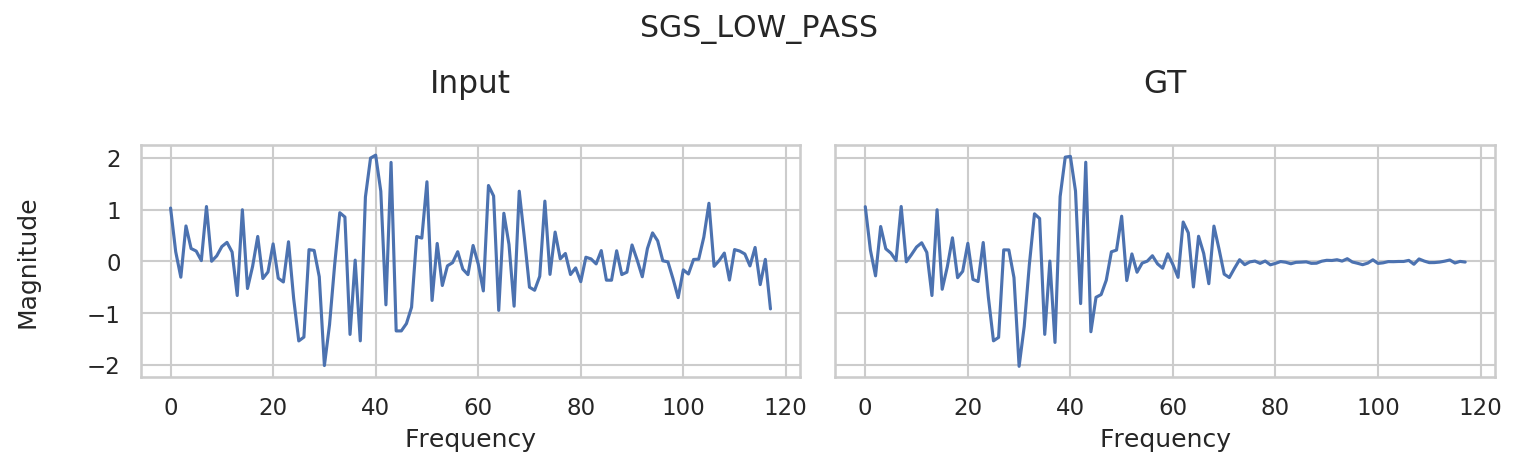

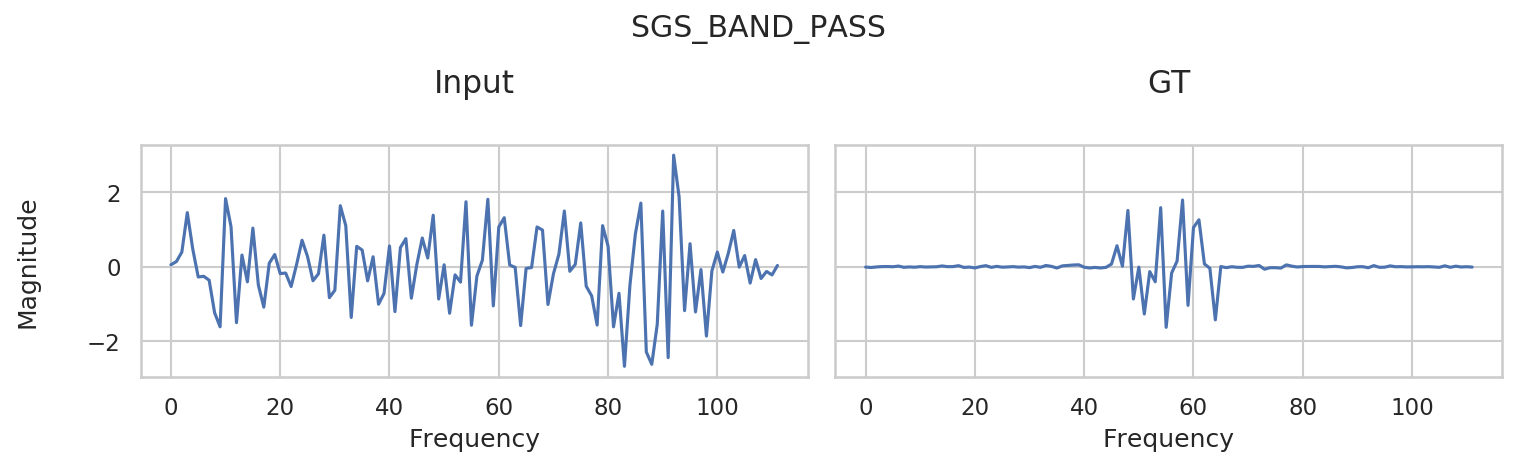

In [8]:
for dataset_kind in functions:
    f = open(dataset_kind + '.pkl', 'rb')
    train_split, val_split, test_split = pickle.load(f)
    
    inputs, labels = test_split
    idx = np.random.randint(0, len(inputs))
    G, Y = inputs[idx], labels[idx]
    Lam, U = adj_eig_decomp(G)

    plot_spectrum(G, [G.ndata['feat'], Y], U, title_ls=['Input', 'GT'], name=dataset_kind)
